# Object Detection on a Custom Dataset using YOLO v5

Yolov5 is a modern, fast and pretty accurate object detection model for images and video streams. There is no secure information about the paternity of it, but we will use the open source version of the model released by Ultralytics [https://ultralytics.com/]. Starting from our self-labeled custom dataset, we are going to finetune yolov5 on it, making it learn to recognize fire and smoke from input images. In this notebook we will train a model that works on thermal pictures.


First of all, we check the GPU power at our disposal:

In [ ]:
!nvidia-smi

Mon May 30 09:22:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


## Prerequisites

We'll install [Apex by NVIDIA](https://nvidia.github.io/apex/) to speed up the training of our model. Apex is a Pytorch extension with NVIDIA-maintained utilities to streamline mixed precision and distributed training, in order to speed-up computation and optimize parallelization over multiple GPUs

In [ ]:
!rm -r /content/apex
!git clone https://github.com/NVIDIA/apex
!cd apex
!pip install -v --disable-pip-version-check --no-cache-dir /content/apex

rm: cannot remove '/content/apex': No such file or directory
Cloning into 'apex'...
remote: Enumerating objects: 9751, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (432/432), done.
remote: Total 9751 (delta 527), reused 594 (delta 371), pack-reused 8929
Receiving objects: 100% (9751/9751), 14.84 MiB | 27.24 MiB/s, done.
Resolving deltas: 100% (6638/6638), done.
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /

## Import the dataset

In [ ]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import os
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

from pylab import rcParams
import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! rm -r trainingSet
! unzip -q '/content/drive/Shareddrives/SEAI Project/Dataset/trainingSet_AllThermal.zip'

rm: cannot remove 'trainingSet': No such file or directory


In [ ]:
! mkdir /content/trainingSet/images
! mkdir /content/trainingSet/labels
! mv /content/trainingSet/*.txt /content/trainingSet/labels
! mv /content/trainingSet/*.* /content/trainingSet/images

In [ ]:
NUM_CLASSES=2
classes=['Fire', 'Smoke']
IMAGE_DIR = '/content/trainingSet/images'
LABEL_DIR = '/content/trainingSet/labels'

In [ ]:
np.random.seed(42)
image_list = os.listdir(IMAGE_DIR)
image_list.sort()
train_images, val_images = train_test_split(image_list, test_size=0.20)
val_images, test_images = train_test_split(val_images, test_size=0.25)

np.random.seed(42)
label_list = os.listdir(LABEL_DIR)
label_list.sort()
train_labels, val_labels = train_test_split(label_list, test_size=0.20)
val_labels, test_labels = train_test_split(val_labels, test_size=0.25)

In [ ]:
print(train_images[0], train_images[1001], train_images[-1])
print(train_labels[0], train_labels[1001], train_labels[-1])
print()
print(val_images[0], val_images[40], val_images[-1])
print(val_labels[0], val_labels[40], val_labels[-1])
print()
print(test_images[0], test_images[10], test_images[-1])
print(test_labels[0], test_labels[10], test_labels[-1])
print()
print(len(train_images), len(val_images), len(test_images))
print(len(train_labels), len(val_labels), len(test_labels))

c01138.jpg b00058.jpg c00717.jpg
c01138.txt b00058.txt c00717.txt

c00791.jpg c00580.jpg b00312.jpg
c00791.txt c00580.txt b00312.txt

b00144.jpg c00541.jpg c00219.jpg
b00144.txt c00541.txt c00219.txt

1275 239 80
1275 239 80


### Sample image and annotation

Let's have a look at an image from the dataset.

['0 0.368467 0.778338 0.064998 0.052057\n', '0 0.589152 0.724181 0.063680 0.061293\n', '0 0.669082 0.739715 0.092666 0.090680\n', '0 0.766579 0.601175 0.040843 0.058774\n', '0 0.985727 0.735097 0.025911 0.059614\n']


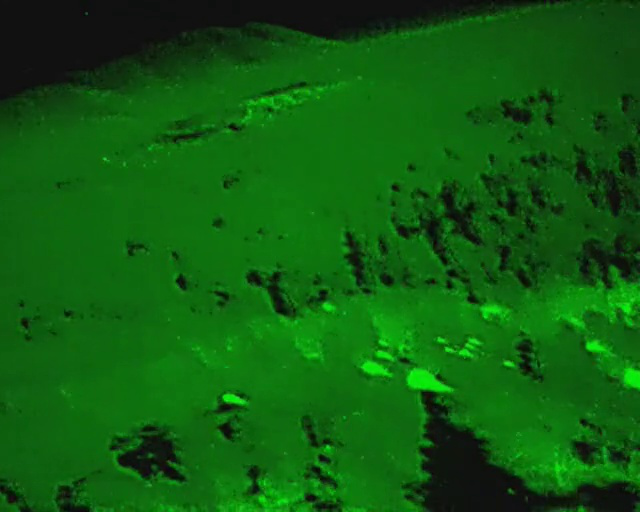

In [ ]:
img_path = train_images[10]
label_path = train_labels[10]

img = Image.open(os.path.join(IMAGE_DIR, img_path)).convert('RGB')
with (open(os.path.join(LABEL_DIR, label_path), "r")) as f:
  label = f.readlines()

print(label)
img

In [ ]:
from torchvision.transforms.transforms import Compose
from torchvision.transforms import ToTensor, PILToTensor, Compose

def img_to_tensor(img):
  transform = Compose([PILToTensor()])
  tensor = transform(img)
  return tensor

img_to_tensor(img).shape

torch.Size([3, 512, 640])

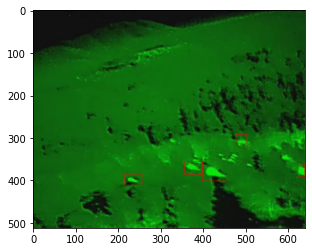

In [ ]:
import cv2
import matplotlib.pyplot as plt

def draw_img_with_bounding_boxes(img, tensor, label): 
  img = np.array(img)
  _, dh, dw = tensor.shape
  for row in label:

    # Split string to float
    class_type, x, y, w, h = map(float, row.split(' '))

    # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    if class_type == 0: #Fire
      cv2.rectangle(img, (l, t), (r, b), (255, 0, 0), 1)
    else:
      cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

  plt.imshow(img)

draw_img_with_bounding_boxes(img, img_to_tensor(img), label)

## Create directories for learning sets

In [ ]:
import shutil

! mkdir /content/trainingSet/images/training
! mkdir /content/trainingSet/labels/training
! mkdir /content/trainingSet/images/validation
! mkdir /content/trainingSet/labels/validation
! mkdir /content/trainingSet/images/test
! mkdir /content/trainingSet/labels/test

TRAIN_IMG_DIR = '/content/trainingSet/images/training'
TRAIN_LABELS_DIR = '/content/trainingSet/labels/training'
VAL_IMG_DIR = '/content/trainingSet/images/validation'
VAL_LABELS_DIR = '/content/trainingSet/labels/validation'
TEST_IMG_DIR = '/content/trainingSet/images/test'
TEST_LABELS_DIR = '/content/trainingSet/labels/test'

for (img, label) in zip(train_images, train_labels):
  shutil.move(os.path.join(IMAGE_DIR, img), os.path.join(TRAIN_IMG_DIR, img))
  shutil.move(os.path.join(LABEL_DIR, label), os.path.join(TRAIN_LABELS_DIR, label))

for (img, label) in zip(val_images, val_labels):
  shutil.move(os.path.join(IMAGE_DIR, img), os.path.join(VAL_IMG_DIR, img))
  shutil.move(os.path.join(LABEL_DIR, label), os.path.join(VAL_LABELS_DIR, label))

for (img, label) in zip(test_images, test_labels):
  shutil.move(os.path.join(IMAGE_DIR, img), os.path.join(TEST_IMG_DIR, img))
  shutil.move(os.path.join(LABEL_DIR, label), os.path.join(TEST_LABELS_DIR, label))

print(len(os.listdir(TRAIN_IMG_DIR)), len(os.listdir(VAL_IMG_DIR)), len(os.listdir(TEST_IMG_DIR)))
print(len(os.listdir(TRAIN_LABELS_DIR)), len(os.listdir(VAL_LABELS_DIR)), len(os.listdir(TEST_LABELS_DIR)))

1275 239 80
1275 239 80


In [ ]:
! tree trainingSet -L 2

trainingSet
├── images
│   ├── test
│   ├── training
│   └── validation
└── labels
    ├── test
    ├── training
    └── validation

8 directories, 0 files


## Fine-tuning YOLO v5


### YOLO v5 project setup

YOLO v5 uses PyTorch, but everything is abstracted away


In [ ]:
!rm -r yolov5
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 
!git clone https://github.com/ultralytics/yolov5

rm: cannot remove 'yolov5': No such file or directory
     |████████████████████████████████| 596 kB 35.1 MB/s 
Cloning into 'yolov5'...
remote: Enumerating objects: 13599, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 13599 (delta 87), reused 102 (delta 71), pack-reused 13476
Receiving objects: 100% (13599/13599), 12.11 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (9492/9492), done.


In [ ]:
!pip install -r /content/yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
with(open('/content/yolov5/data/fire.yaml', "w")) as f:
  f.writelines(["train: /content/trainingSet/images/training/\n",
  "val: /content/trainingSet/images/validation/\n",
  "test: /content/trainingSet/images/test/\n",
  "\n",
  "nc: 2\n",
  "\n",
  "names: ['Fire', 'Smoke']"
  ])

In [ ]:
with(open('/content/yolov5/models/yolov5l.yaml', "r")) as f:
   c = f.readlines()
   c[3] = "nc: 2\n"

with(open('/content/yolov5/models/yolov5l.yaml', "w")) as f:
   f.writelines(c)


### Training

To train a model on a custom dataset, we'll call the `train.py` script. We'll pass some of parameters:

- img 254 - size of the images: 254x254
- batch 64 - 64 images per batch
- epochs 30 - train for 30 epochs
- data ./data/clothing.yaml - path to dataset config
- cfg ./models/yolov5l.yaml - model config
- weights yolov5l.pt - use pre-trained weights from the YOLOv5l model
- name yolov5l_clothing - name of our model
- cache - cache dataset images for faster training


In [ ]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 30 \
  --data /content/yolov5/data/fire.yaml --cfg /content/yolov5/models/yolov5l.yaml --weights yolov5l.pt \
  --name yolov5l_fire_AllThermal_images --cache

train: weights=yolov5l.pt, cfg=/content/yolov5/models/yolov5l.yaml, data=/content/yolov5/data/fire.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolov5l_fire_AllThermal_images, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, 

## Evaluation

The project includes a great utility function `plot_results()` that allows you to evaluate your model performance on the last training run:

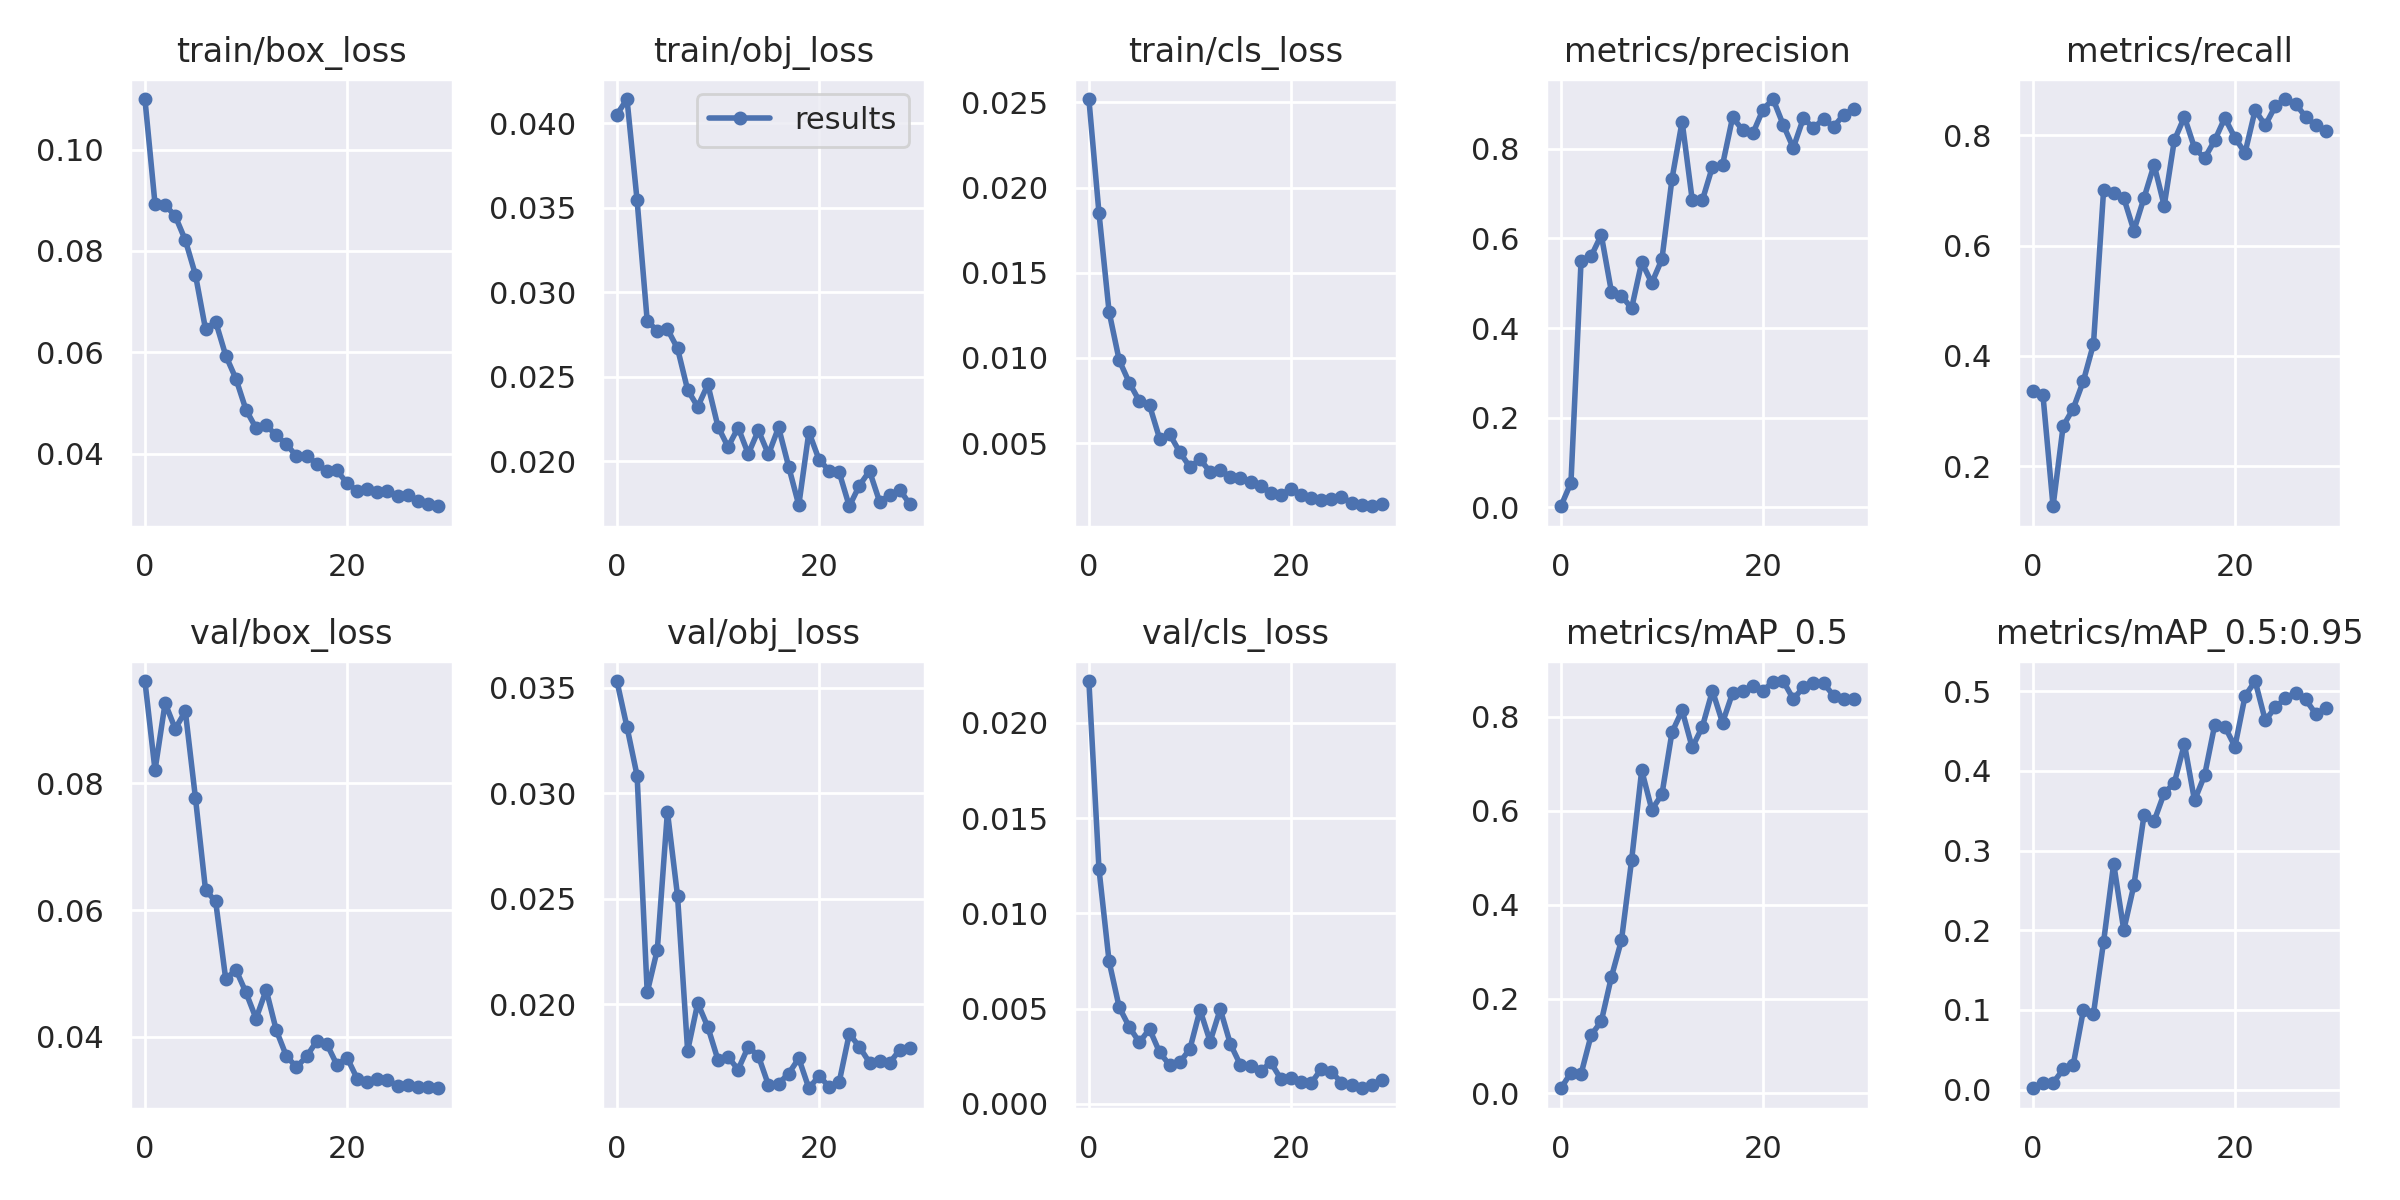

In [ ]:
results = '/content/yolov5/runs/train/yolov5l_fire_thermal_images/results.png'
results_png = Image.open(results)
results_png

## Making predictions

In [ ]:
!python /content/yolov5/detect.py --weights "/content/yolov5/runs/train/yolov5l_fire_AllThermal_images/weights/best.pt" --source "/content/drive/Shareddrives/SEAI Project/Dataset/Video/Test_thermal_fusion_60sec.mp4"

detect: weights=['/content/yolov5/runs/train/yolov5l_fire_AllThermal_images/weights/best.pt'], source=/content/drive/Shareddrives/SEAI Project/Dataset/Video/Test_thermal_fusion_60sec.mp4, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46113663 parameters, 0 gradients, 107.8 GFLOPs
video 1/1 (1/1800) /content/drive/Shareddrives/SEAI Project/Dataset/Video/Test_thermal_fusion_60sec.mp4: 480x640 3 Fires, Done. (0.045s)
video 1/1 (2/1800) /content/drive/Shareddrives/SEAI Project/Dataset/Video/Test_thermal_fusion_60s

We'll write a helper function to show the results:

In [ ]:
!cp /content/trainingSet/images/test/* "/content/yolov5/data/images"

In [ ]:
!python /content/yolov5/detect.py --weights /content/yolov5/runs/train/yolov5l_fire_AllThermal_images/weights/best.pt \
  --img 640 --conf 0.3 --source /content/yolov5/data/images

detect: weights=['/content/yolov5/runs/train/yolov5l_fire_AllThermal_images/weights/best.pt'], source=/content/yolov5/data/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46113663 parameters, 0 gradients, 107.8 GFLOPs
image 1/82 /content/yolov5/data/images/a00015.jpg: 512x640 2 Fires, 1 Smoke, Done. (0.044s)
image 2/82 /content/yolov5/data/images/a00023.jpg: 512x640 3 Fires, Done. (0.033s)
image 3/82 /content/yolov5/data/images/a00044.jpg: 512x640 4 Fires, Done. (0.031s)
image 4/82 /content/yolov5/data/im

In [ ]:
def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (254, 254), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = np.array([load_image(img) for img in image_paths])
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=4)
  plt.figure(figsize=(200, 30))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [ ]:
img_paths = list(Path("/content/yolov5/runs/detect/exp4").glob("*.jpg"))[:16]
show_grid(img_paths)

Output hidden; open in https://colab.research.google.com to view.

## Save resulting model

In [ ]:
!zip -r '/content/drive/Shareddrives/SEAI Project/Models/Yolov5/yolov5l_Allthermal.zip'  "/content/yolov5"

  adding: content/yolov5/ (stored 0%)
  adding: content/yolov5/README.md (deflated 72%)
  adding: content/yolov5/.gitattributes (deflated 4%)
  adding: content/yolov5/tutorial.ipynb (deflated 78%)
  adding: content/yolov5/LICENSE (deflated 66%)
  adding: content/yolov5/requirements.txt (deflated 50%)
  adding: content/yolov5/models/ (stored 0%)
  adding: content/yolov5/models/yolov5s.yaml (deflated 60%)
  adding: content/yolov5/models/__init__.py (stored 0%)
  adding: content/yolov5/models/yolov5l.yaml (deflated 61%)
  adding: content/yolov5/models/yolov5m.yaml (deflated 60%)
  adding: content/yolov5/models/hub/ (stored 0%)
  adding: content/yolov5/models/hub/yolov3-spp.yaml (deflated 63%)
  adding: content/yolov5/models/hub/yolov5x6.yaml (deflated 65%)
  adding: content/yolov5/models/hub/yolov5m6.yaml (deflated 65%)
  adding: content/yolov5/models/hub/anchors.yaml (deflated 72%)
  adding: content/yolov5/models/hub/yolov5-p34.yaml (deflated 62%)
  adding: content/yolov5/models/hub/yolo

## References

- [YOLOv5 GitHub](https://github.com/ultralytics/yolov5)
- [YOLOv5 Train on Custom Data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)
- [NVIDIA Apex on GitHub](https://github.com/NVIDIA/apex)